In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from acquire import *
from prepare_nlp_josh import *
import env
import json
from requests import get
from json.decoder import JSONDecodeError
from bs4 import BeautifulSoup
import time
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer
#You can also call the Porter by nltk.porter.PorterStemmer
from nltk.stem.snowball import EnglishStemmer


from nltk.stem import WordNetLemmatizer
from nltk.book import *
from nltk.text import Text


import env
#nltk.download("punkt")
#nltk.download("stopwords")
#nltk.download('averaged_perceptron_tagger')
#nltk.download('tagsets')
#nltk.download("maxent_ne_chunker")
#nltk.download("words")
#nltk.download("book") #big download

In [2]:
"""
REPOS = [
    "gocodeup/codeup-setup-script",
    "gocodeup/movies-application",
    "torvalds/linux",
]
"""

'\nREPOS = [\n    "gocodeup/codeup-setup-script",\n    "gocodeup/movies-application",\n    "torvalds/linux",\n]\n'

In [3]:
links = pd.read_csv("links.csv", index_col="Unnamed: 0")

In [4]:
#When you get new links, delete this line.
links.href = links.href.str[1:]

In [5]:
links.head()

,href
0,learn-co-students/simple-blackjack-cli-prework
1,rocketacademy/basics-blackjack
2,datamllab/rlcard
3,learn-co-students/simple-blackjack-cli-001-pre...
4,cocos-creator/tutorial-blackjack-deprecated


In [6]:
#Run this to get new data
#df = get_repo_contents(links.href)

In [7]:
#Run to save the data
#df = pd.to_csv("origional_data.csv", index=False)

In [8]:
df = pd.read_csv("original_data.csv")

In [9]:
df.language.value_counts()

Ruby                216
Java                 52
JavaScript           40
Python               36
C#                   15
C++                   9
Swift                 7
HTML                  5
CSS                   5
TypeScript            4
Lua                   3
Objective-C           3
Jupyter Notebook      3
Vue                   2
Rust                  2
Kotlin                2
PHP                   2
Go                    2
Dart                  2
C                     1
Haskell               1
Visual Basic          1
Elixir                1
Roff                  1
Clojure               1
Solidity              1
Shell                 1
Name: language, dtype: int64

In [10]:
def lemmatize(input_string):
    """
    Takes an input string and lemmatizes it.
    Please do not stem and lemmatize the same string.
    """
    #Creates the lemmatizer object
    wnl = nltk.stem.WordNetLemmatizer()
    
    #Makes lemmatade
    lemmas = [wnl.lemmatize(word) for word in input_string.split()]
    lemmatized_string = " ".join(lemmas)
    
    return lemmatized_string

In [11]:
word = """A beginning is the time for taking the most delicate care that the balances are correct. This every sister of the Bene Gesserit knows. To begin your study of the life of Muad'Dib, then, take care that you first place him in his time: born in the 57th year of the Padishah Emperor, Shaddam IV. And take the most special care that you locate Muad'Dib in his place: the planet Arrakis. Do not be deceived by the fact that he was born on Caladan and lived his first fifteen years there. Arrakis, the planet known as Dune, is forever his place."""

In [13]:
words = tokenized(word, tokenize_tool=2)

In [14]:
stop_words = set(stopwords.words("english"))

In [15]:
filtered_list = [word for word in words if word.casefold() not in stop_words]

- Understemming: Two related words should be reduced to the same stem but aren't. False negative.
- Overstemming: Two unrelated words are reduced to the same stem even though they shouldn't be. False positive.

- Consider Snowball stemmer aka Porter2

In [16]:
stemmed_words = stemmertize_tool(words)

In [17]:
stemmed_words

['a',
 'begin',
 'is',
 'the',
 'time',
 'for',
 'take',
 'the',
 'most',
 'delic',
 'care',
 'that',
 'the',
 'balanc',
 'are',
 'correct',
 '.',
 'thi',
 'everi',
 'sister',
 'of',
 'the',
 'bene',
 'gesserit',
 'know',
 '.',
 'to',
 'begin',
 'your',
 'studi',
 'of',
 'the',
 'life',
 'of',
 "muad'dib",
 ',',
 'then',
 ',',
 'take',
 'care',
 'that',
 'you',
 'first',
 'place',
 'him',
 'in',
 'hi',
 'time',
 ':',
 'born',
 'in',
 'the',
 '57th',
 'year',
 'of',
 'the',
 'padishah',
 'emperor',
 ',',
 'shaddam',
 'iv',
 '.',
 'and',
 'take',
 'the',
 'most',
 'special',
 'care',
 'that',
 'you',
 'locat',
 "muad'dib",
 'in',
 'hi',
 'place',
 ':',
 'the',
 'planet',
 'arraki',
 '.',
 'do',
 'not',
 'be',
 'deceiv',
 'by',
 'the',
 'fact',
 'that',
 'he',
 'wa',
 'born',
 'on',
 'caladan',
 'and',
 'live',
 'hi',
 'first',
 'fifteen',
 'year',
 'there',
 '.',
 'arraki',
 ',',
 'the',
 'planet',
 'known',
 'as',
 'dune',
 ',',
 'is',
 'forev',
 'hi',
 'place',
 '.']

### Tagging Parts of Speech

In [18]:
tagged_words = nltk.pos_tag(words)

In [19]:
type(tagged_words)

list

In [20]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

### Lemmatize words

In [21]:
lemmatizer = WordNetLemmatizer()

In [22]:
lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

In [23]:
type(lemmatized_words)

list

In [24]:
for i in range(len(lemmatized_words)):
    print(f' lemmatized_words: {lemmatized_words[i]} ---- tagged word: {tagged_words[i]}')

 lemmatized_words: A ---- tagged word: ('A', 'DT')
 lemmatized_words: beginning ---- tagged word: ('beginning', 'NN')
 lemmatized_words: is ---- tagged word: ('is', 'VBZ')
 lemmatized_words: the ---- tagged word: ('the', 'DT')
 lemmatized_words: time ---- tagged word: ('time', 'NN')
 lemmatized_words: for ---- tagged word: ('for', 'IN')
 lemmatized_words: taking ---- tagged word: ('taking', 'VBG')
 lemmatized_words: the ---- tagged word: ('the', 'DT')
 lemmatized_words: most ---- tagged word: ('most', 'RBS')
 lemmatized_words: delicate ---- tagged word: ('delicate', 'JJ')
 lemmatized_words: care ---- tagged word: ('care', 'NN')
 lemmatized_words: that ---- tagged word: ('that', 'IN')
 lemmatized_words: the ---- tagged word: ('the', 'DT')
 lemmatized_words: balance ---- tagged word: ('balances', 'NNS')
 lemmatized_words: are ---- tagged word: ('are', 'VBP')
 lemmatized_words: correct ---- tagged word: ('correct', 'JJ')
 lemmatized_words: . ---- tagged word: ('.', '.')
 lemmatized_words:

### Grammer Tagger

In [25]:
grammar = "NP: {<DT>?<JJ>*<NN>}"

In [26]:
chunk_parser = nltk.RegexpParser(grammar)

In [27]:
tree = chunk_parser.parse(tagged_words)

In [28]:
#tree.draw()

In [31]:
grammar = """
Chunk: {<.*>+}
       }<JJ>{"""

In [32]:
grammar0 = r"""
NP: {<DT|PP\$>?<JJ>*<NN>}   # chunk determiner/possessive, adjectives and noun
    {<NNP>+}                # chunk sequences of proper nouns
"""

In [33]:
chunk_parser = nltk.RegexpParser(grammar)

In [34]:
chunk_parser

<chunk.RegexpParser with 1 stages>

In [35]:
tree = chunk_parser.parse(tagged_words)

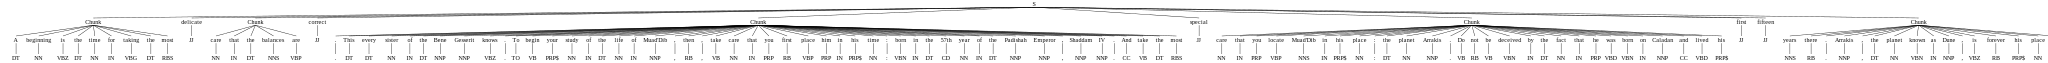

In [36]:
tree

In [37]:
#tree.draw()

In [38]:
tree0 = nltk.ne_chunk(tagged_words)

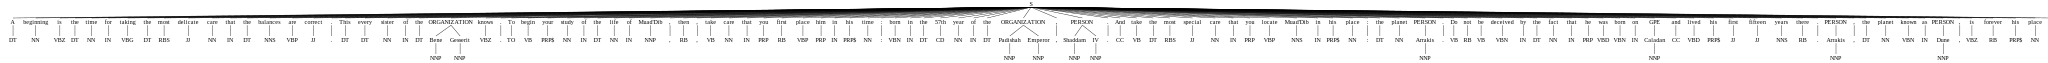

In [39]:
tree0

In [40]:
extract_proper_nouns(word)

{'Arrakis',
 'Bene Gesserit',
 'Caladan',
 'Dune',
 'Padishah Emperor',
 'Shaddam IV'}

### Concordance

- Takes a list

https://www.nltk.org/api/nltk.text.Text.html?highlight=concordance#nltk.text.Text.concordance

In [50]:
dune = """A beginning is the time for taking the most delicate care that the balances are correct. This every sister of the Bene Gesserit knows. To begin your study of the life of Muad'Dib, then, take care that you first place him in his time: born in the 57th year of the Padishah Emperor, Shaddam IV. And take the most special care that you locate Muad'Dib in his place: the planet Arrakis. Do not be deceived by the fact that he was born on Caladan and lived his first fifteen years there. Arrakis, the planet known as Dune, is forever his place."""

In [62]:
text = Text(filtered_list)

In [63]:
type(text)

nltk.text.Text

In [69]:
match_list = text.concordance("time")

Displaying 2 of 2 matches:
beginning time taking delicate care balances correc
e Muad'Dib , , take care first place time : born 57th year Padishah Emperor , 


In [72]:
print(match_list)

None
